# Statistical Modeling

In addition to making use of the network algorithms discussed in the other chapters in this section, it can also be useful to analyze a network using statistical modeling and machine learning methods. In order to do this, the network must be converted into a tabular format so that can be analyzed using these techniques.

A popular method for transforming a network in this way is [node2vec](https://snap.stanford.edu/node2vec/), which converts a network's nodes into numerical vectors using random walks. This method transforms random walks into arrays of numbers in a manner similar to what [word2vec](https://en.wikipedia.org/wiki/Word2vec) does with sentences.

As an example, we'll use a network from the literary journal *The Crisis*, which [Melanie Walsh derived from the Modernist Journals Project metadata](https://github.com/melaniewalsh/sample-social-network-datasets/tree/master/sample-datasets/modernist-journals-project).

## Converting Data with node2vec

First you will need to import libraries, including a new library for node2vec that you may need to install.

In [1]:
import networkx as nx
import pandas as pd
from node2vec import Node2Vec # You must run `pip install node2vec` in the  terminal for this to work
from sklearn.cluster import KMeans

Then import the data: first as a pandas dataframe and then as a NetworkX graph object.

In [2]:
# Import a CSV of Marvel character co-occurrences.
crisis = pd.read_csv("../data/crisis-edges.csv")

G = nx.from_pandas_edgelist(crisis, source="Source", target="Target", edge_attr=True)
print(G)

Graph with 96 nodes and 273 edges


The node2vec algorithm has [several important hyperparameters](https://github.com/eliorc/node2vec), but the library we are using includes sensible defaults. However, there are two hyperparameters you must set yourself and think carefully about:

- **the Return parameter, p**: this controls the likelihood that, on a random walk, the path will return to the node from which it just departed.
- **the In-Out parameter, q**: this controls the likelihood that, in the same random walk, the path will tend toward nodes that go farther away ("out") from the original node rather than stay nearby ("in").

1 is a relatively neutral value for each of these parameters. To get node vectors that emphasize community or homophily, the creators of node2vec recommend setting p to $1$ and q to $.5$.

```{seealso}
For more information, you can read [the original node2vec paper on arXiv](https://doi.org/10.48550/arXiv.1607.00653).
```

With our hyperparameters determined, you can fit the node2vec algorithm, which runs all the random walks.

In [3]:
node2vec = Node2Vec(G, dimensions=128, workers=1, p=1, q=.5, weight_key=None)
model = node2vec.fit()

Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

Generating walks (CPU: 1):   0%|                         | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1):  70%|███████████▉     | 7/10 [00:00<00:00, 68.92it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 59.58it/s]

Behind the scenes in the code above, the node2vec module performs the random walks and then turns those walks into vectors using word2vec. Now that this process is finished, you can use the vectors to discover nodes that our similar. You can look for the nodes in this network that are most similar to W.E.B. Du Bois.

In [4]:
model.wv.most_similar("Du Bois, W. E. B.")

[('Frazier, C. Emily', 0.8393535614013672),
 ('Brown and Dawson', 0.794838547706604),
 ('Shillady, John R.', 0.7882602214813232),
 ('Richardson, Willis', 0.7689587473869324),
 ('Allison, Madeline G.', 0.7625157833099365),
 ('J. F.', 0.7581290006637573),
 ('Battey', 0.7579095363616943),
 ('Stoddard, Yetta Kay', 0.7485406994819641),
 ('Francique, John', 0.6882055401802063),
 ('Jackson, May Howard', 0.6857362985610962)]

```{note}
The `wv` in the code above refers to "word vectors", because this code is performing [Gensim's](https://radimrehurek.com/gensim/index.html) version of the word2vec algorithm.
```

## Modeling with node2vec Results

Now that you've generated some node vectors, you will want to use those vectors to perform some kind of machine learning task. In this example, you'll carry out some very simple unsupervised K-means clustering using [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means). This method clusters data based on the kinds of distances you generated above. Running K-means clustering on our node vectors is likely to reveal the homophilous communities in our network, working as a kind of community detection.

First, you will need to get all the normalized vectors from your node2vec model. You can generate them with a list comprehension and turn them into a pandas DataFrame.

In [5]:
features = [model.wv.get_vector(n, norm=True) for n in G.nodes()]
features = pd.DataFrame(features, index=list(G.nodes()))
features

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
"Latimer, Louise R.",0.010694,-0.156090,0.073683,0.243429,0.055850,-0.051713,-0.004572,0.009595,-0.002716,0.028260,...,-0.024714,-0.046368,-0.008447,0.033112,-0.079532,0.035680,-0.067217,-0.033471,0.064332,0.087325
"Johnson, Georgia Douglas",-0.046239,-0.125418,0.115517,0.204317,0.041156,-0.105095,-0.058304,0.008459,-0.019985,-0.089319,...,0.013593,-0.126389,-0.062409,0.090054,-0.049235,0.028397,-0.072940,-0.090023,-0.014660,0.081522
"Allison, M. G.",-0.093285,-0.098143,0.101781,0.197165,-0.009700,0.012125,-0.026383,0.156547,0.013823,-0.029218,...,-0.068622,-0.176969,-0.038999,-0.082607,0.098121,0.058107,0.011595,0.036533,-0.128149,0.036823
"Allison, Madeline G.",0.011815,-0.061496,0.178063,0.063565,-0.038468,-0.096521,0.109092,0.126700,-0.015623,0.042885,...,-0.049304,-0.058742,-0.039670,-0.146464,-0.030417,-0.027970,0.021620,0.013774,-0.133297,0.077317
"Jordan, Winifred Virginia",-0.070809,-0.125881,0.104250,0.186772,-0.053438,-0.050657,0.014872,0.147012,0.006848,-0.093192,...,-0.091908,-0.167876,-0.014781,-0.049862,0.088513,-0.035917,0.059731,0.007101,-0.126895,0.023122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Terrell, Mary Church",0.048574,-0.036187,0.198991,0.064952,0.014905,0.009337,-0.034885,0.048855,0.004945,-0.172794,...,0.117507,0.152482,-0.207073,-0.168231,0.002546,-0.002358,-0.003228,0.008220,-0.109081,0.015237
"Talbert, Mary B.",0.004856,-0.157313,0.058926,0.221174,0.083957,-0.052258,-0.005490,0.028070,-0.001302,-0.007849,...,-0.003373,-0.086620,-0.039008,0.049640,-0.077129,0.041558,-0.066417,-0.031914,0.057365,0.102113
"Carter, George R.",-0.025796,-0.139403,0.103842,0.266436,0.058898,0.008191,-0.007824,-0.002036,0.020378,-0.074531,...,0.007420,-0.029566,-0.007243,0.037903,-0.048558,0.037067,-0.080737,-0.090939,0.068823,0.125265
"Lewin, Rose Dorothy",-0.030120,-0.180783,0.062487,0.277372,0.070567,-0.043933,-0.012855,0.039273,-0.010712,-0.016853,...,0.005501,-0.059525,-0.050555,0.026783,-0.049568,0.038709,-0.014546,-0.007365,0.065976,0.133569


Next you can generate potential categories using K-means. Since this algorithm lets you select the number of groups you expect to find, let's try generating 3 groups of nodes.

In [6]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto', random_state=0)

Once you've run K-means clustering, you can access the group labels using `kmeans.labels_`. To see how the algorithm did, you can use these group labels as colors in a NetworkX visualization of the network.

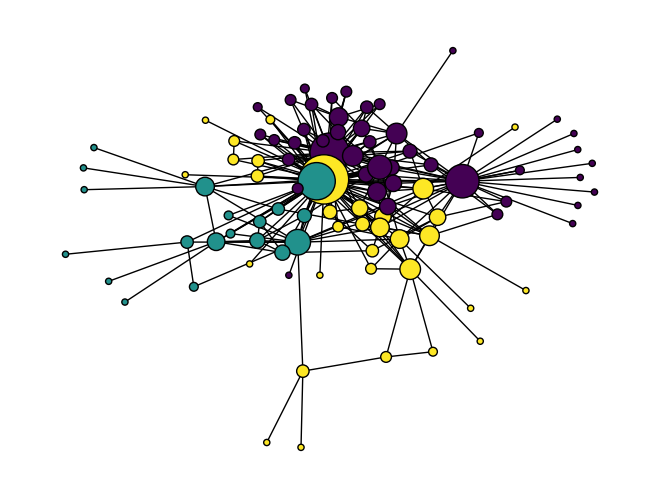

In [7]:
color = kmeans.labels_
size = [n*20 for n in dict(nx.degree(G)).values()]
nx.draw(G, node_color=color, node_size=size, edgecolors="#000")

Node2Vec has succeeded in identifying nodes that are near one another as similar. It could be interesting to compare this method to the community detection algorithms we learned in the last section. 

Though community detection is a common use of node2vec, once you've generated the vectors you can use them for a wide range of supervised and unsupervised machine learning tasks.